In [1]:
import pandas as pd
import numpy as np
import os, pdb, sys, pickle
import matplotlib.pyplot as plt
import scipy.stats as stats

with open('results_2.pkl', 'rb') as f: 
    dct = pickle.load(f)
print(dct.keys())
print(dct['chg_var'].keys())

# Select a dataset with significant drift to use for comparison
# df = dct['mix_shift']['30-30']
df = dct['chg_var']['30-30']
df = df.reset_index(drop = True)
for col in df.columns: 
    df[col] = df[col].fillna(np.nanmean(df[col]))

window_size = 200
p_thresh = 0.001
df.head()

dict_keys(['chg_var', 'cov_shift', 'mix_shift'])
dict_keys(['0.0001-30', '0.001-30', '0.01-30', '0.1-30', '0.6-30', '1-30', '5-30', '10-30', '20-30', '30-30'])


,x1,x2,x3,y,time,pe
0,0.496714,1.399355,-0.675178,1.220891,0,0.0
1,-0.138264,0.924634,-0.144519,0.641851,1,0.0
2,0.647689,0.059630,-0.792420,-0.085101,2,0.0
3,1.523030,-0.646937,-0.307962,0.568132,3,0.0
4,-0.234153,0.698223,-1.893615,-1.429545,4,0.0


# KS Test

FIRST NOTICE OF DRIFT: 1061


Text(0.5, 1.0, 'ks drift indication')

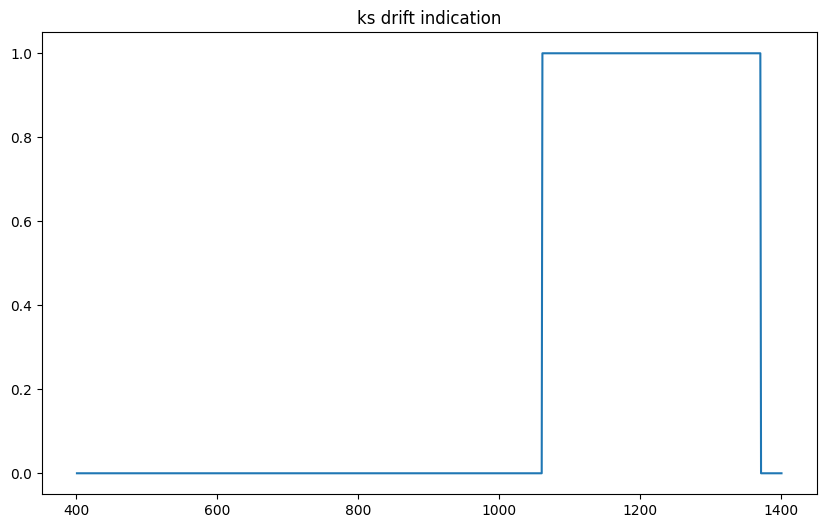

In [2]:
a0, a1 = 0, window_size
b0, b1 = window_size+1, window_size + window_size+1
time, drift_ind = [], []
while b1 <= len(df): 
    drift = 0
    dfa = df.iloc[a0:a1+1]
    dfb = df.iloc[b0:b1+1]

    xa = np.array(dfa['x1'])
    xb = np.array(dfb['x1'])

    ks, pv = stats.ks_2samp(xa, xb)
    if pv <= p_thresh: drift = 1
    time.append(b1)
    drift_ind.append(drift)

    # Iterate
    a0 += 1
    a1 += 1
    b0 += 1
    b1 += 1


ks_results = pd.DataFrame({'time': time, 'drift': drift_ind})
print("FIRST NOTICE OF DRIFT: " + str(min(ks_results[ks_results['drift'] == 1]['time'])))
plt.figure(figsize=(10,6))
plt.plot(ks_results['time'], ks_results['drift'])
plt.title('ks drift indication')

# Hotelling's T-Squared Test

FIRST NOTICE OF DRIFT: 943


Text(0.5, 1.0, 'hotelling drift indication')

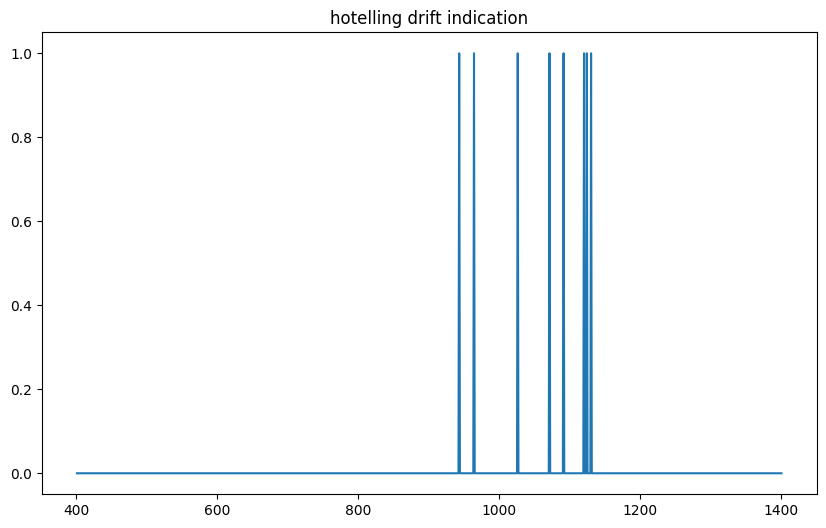

In [3]:
from hotelling.stats import hotelling_t2

a0, a1 = 0, window_size
b0, b1 = window_size+1, window_size + window_size+1
time, drift_ind = [], []
while b1 <= len(df): 
    drift = 0
    dfa = df.iloc[a0:a1+1][['x1', 'x2', 'x3', 'y']]
    dfb = df.iloc[b0:b1+1][['x1', 'x2', 'x3', 'y']]
    
    try: 
        res = hotelling_t2(dfa, dfb)
        ts, pv = res[0], res[2]
    except: 
        pv = 1

    if pv <= p_thresh: drift = 1
    time.append(b1)
    drift_ind.append(drift)

    # Iterate
    a0 += 1
    a1 += 1
    b0 += 1
    b1 += 1


h2_results = pd.DataFrame({'time': time, 'drift': drift_ind})
print("FIRST NOTICE OF DRIFT: " + str(min(h2_results[h2_results['drift'] == 1]['time'])))
plt.figure(figsize=(10,6))
plt.plot(h2_results['time'], h2_results['drift'])
plt.title('hotelling drift indication')

# Population Stability Index

In [4]:
def calculate_psi(expected, actual, buckets=10):
    def scale_range(input, min, max):
        input += -(np.min(input))
        input /= np.max(input) / (max - min)
        input += min
        return input

    def psi(expected_array, actual_array, buckettype='bins', buckets=10, axis=0):
        if buckettype == 'bins':
            breakpoints = np.linspace(0, 1, buckets + 1)
            expected_percents = np.histogram(expected_array, breakpoints)[0] / len(expected_array)
            actual_percents = np.histogram(actual_array, breakpoints)[0] / len(actual_array)
        elif buckettype == 'quantiles':
            breakpoints = np.percentile(expected_array, np.linspace(0, 100, buckets + 1))
            expected_percents = np.histogram(expected_array, breakpoints)[0] / len(expected_array)
            actual_percents = np.histogram(actual_array, breakpoints)[0] / len(actual_array)

        psi_value = np.sum((expected_percents - actual_percents) * np.log(expected_percents / actual_percents))
        return psi_value

    expected_array = np.array(expected)
    actual_array = np.array(actual)

    psi_value = psi(expected_array, actual_array, buckets=buckets)
    return psi_value

C:\Users\cshul\AppData\Local\Temp\ipykernel_13368\422066584.py:18: RuntimeWarning: divide by zero encountered in divide
  psi_value = np.sum((expected_percents - actual_percents) * np.log(expected_percents / actual_percents))
C:\Users\cshul\AppData\Local\Temp\ipykernel_13368\422066584.py:18: RuntimeWarning: invalid value encountered in divide
  psi_value = np.sum((expected_percents - actual_percents) * np.log(expected_percents / actual_percents))


FIRST NOTICE OF DRIFT: 780


Text(0.5, 1.0, 'psi drift indication')

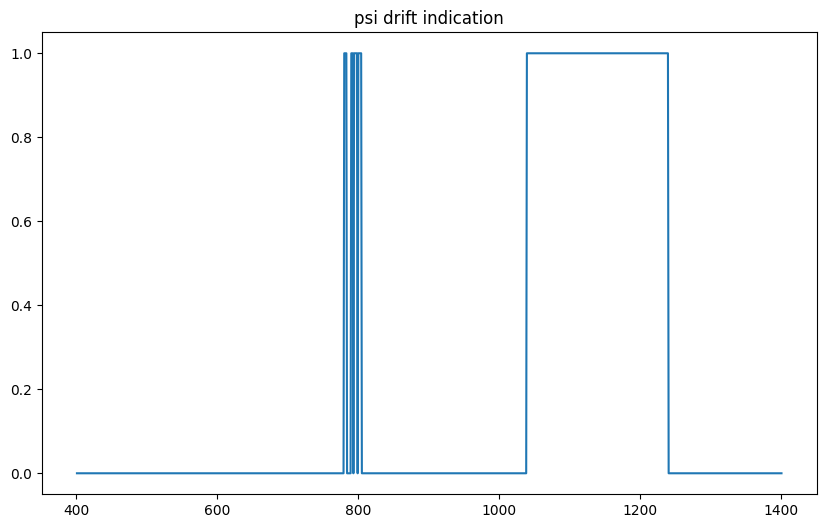

In [5]:
a0, a1 = 0, window_size
b0, b1 = window_size+1, window_size + window_size+1
time, drift_ind = [], []
while b1 <= len(df): 
    drift = 0
    dfa = df.iloc[a0:a1+1]
    dfb = df.iloc[b0:b1+1]

    xa = np.array(dfa['x1'])
    xb = np.array(dfb['x1'])

    psi = calculate_psi(xa, xb)
    if psi > 0.25: drift = 1
    time.append(b1)
    drift_ind.append(drift)

    # Iterate
    a0 += 1
    a1 += 1
    b0 += 1
    b1 += 1

psi_results = pd.DataFrame({'time': time, 'drift': drift_ind})
print("FIRST NOTICE OF DRIFT: " + str(min(psi_results[psi_results['drift'] == 1]['time'])))  
plt.figure(figsize=(10,6))
plt.plot(psi_results['time'], psi_results['drift'])
plt.title('psi drift indication')

# T Test on PE Vector

FIRST NOTICE OF DRIFT: 535


Text(0.5, 1.0, 'PE drift indication')

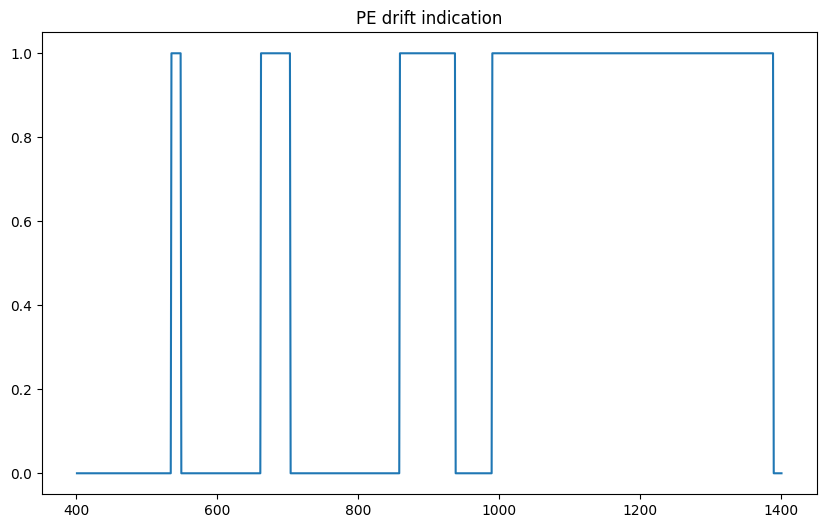

In [6]:
from scipy.stats import ttest_ind
a0, a1 = 0, window_size
b0, b1 = window_size+1, window_size + window_size+1
time, drift_ind = [], []
while b1 <= len(df): 
    drift = 0
    dfa = df.iloc[a0:a1+1]
    dfb = df.iloc[b0:b1+1]

    xa = np.array(dfa['pe'])
    xb = np.array(dfb['pe'])

    ts, pv = ttest_ind(xa, xb)
    if pv <= p_thresh: drift = 1
    time.append(b1)
    drift_ind.append(drift)

    # Iterate
    a0 += 1
    a1 += 1
    b0 += 1
    b1 += 1
    
pe_results = pd.DataFrame({'time': time, 'drift': drift_ind})
print("FIRST NOTICE OF DRIFT: " + str(min(pe_results[pe_results['drift'] == 1]['time'])))  
plt.figure(figsize=(10,6))
plt.plot(pe_results['time'], pe_results['drift'])
plt.title('PE drift indication')

# Combine Results for Visual

In [11]:
# ks, h2, psi, pe
df = ks_results.copy(deep = True)
df.columns = ['time', 'ks']

h2_results.columns = ['time', 'h2']
psi_results.columns = ['time', 'psi']
pe_results.columns = ['time', 'pe']

df = pd.merge(df, h2_results, how = 'left', on = 'time')
df = pd.merge(df, psi_results, how = 'left', on = 'time')
df = pd.merge(df, pe_results, how = 'left', on = 'time')
df.head()

,time,ks,h2,psi,pe
0,401,0,0,0,0
1,402,0,0,0,0
2,403,0,0,0,0
3,404,0,0,0,0
4,405,0,0,0,0


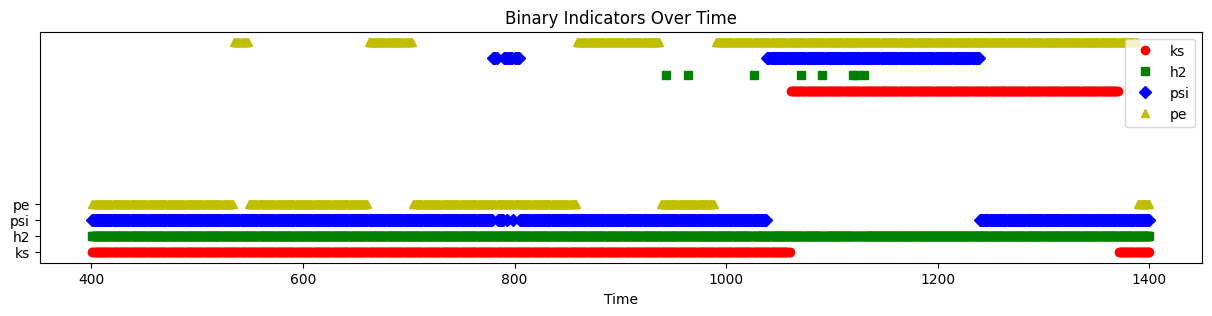

In [12]:
# Create the plot
plt.figure(figsize=(15, 3))

# Define markers and offsets for each column
markers = ['o', 's', 'D', '^']
offsets = [0, 0.1, 0.2, 0.3]
colors = ['r', 'g', 'b', 'y']

for i, column in enumerate(df.columns[1:]):
    plt.plot(df['time'], df[column] + offsets[i], marker=markers[i], linestyle='', color=colors[i], label=column)

# Customizing the plot
plt.yticks(offsets, df.columns[1:])
plt.xlabel('Time')
plt.title('Binary Indicators Over Time')
plt.legend(loc='upper right')

plt.show()

In [15]:
df.head()

,ks,h2,psi,pe
time,,,,
401,0,0,0,0
402,0,0,0,0
403,0,0,0,0
404,0,0,0,0
405,0,0,0,0


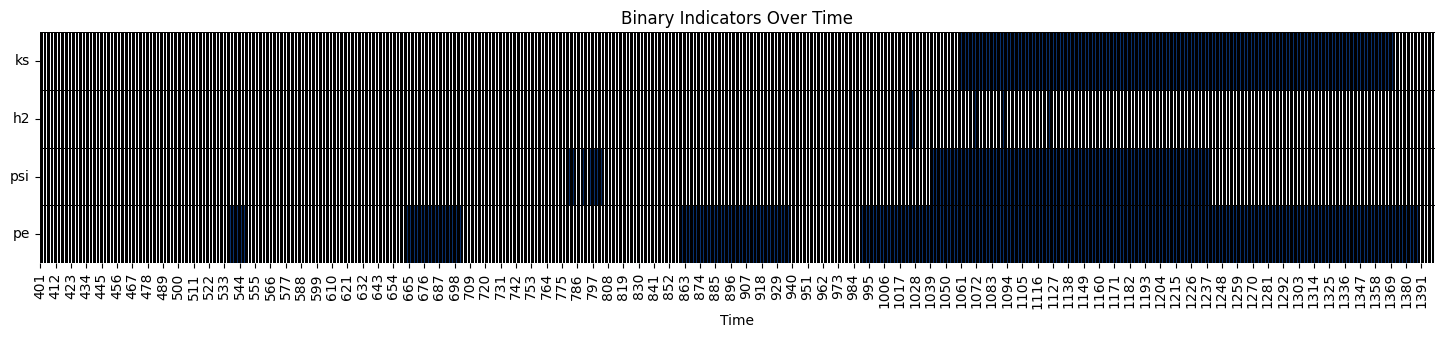

In [17]:
# Set the 'time' column as the index
import seaborn as sns
# df.set_index('time', inplace=True)

# Create a heatmap
plt.figure(figsize=(18, 3))
sns.heatmap(df.T, cmap='Blues', cbar=False, linewidths=0.5, linecolor='black')

# Customizing the plot
plt.xlabel('Time')
plt.title('Binary Indicators Over Time')
plt.yticks(rotation=0)
plt.show()